Time Comparison between Dijkstra's and A* Algorithms: same line
---------------------------------------------------------------------------------------------------
Pair: Baker Street to Marylebone, Dijkstra Time: 0.000067, A* Time: 0.000033
Pair: Baker Street to Regent's Park, Dijkstra Time: 0.000036, A* Time: 0.000034
Pair: Charing Cross to Embankment, Dijkstra Time: 0.000030, A* Time: 0.000028
Pair: Charing Cross to Picadilly Circus, Dijkstra Time: 0.000041, A* Time: 0.000051
Pair: Edgware Road (B) to Paddington, Dijkstra Time: 0.000031, A* Time: 0.000030
Pair: Elephant & Castle to Lambeth North, Dijkstra Time: 0.000035, A* Time: 0.000033
Pair: Harlesden to Stonebridge Park, Dijkstra Time: 0.000031, A* Time: 0.000029
Pair: Harlesden to Willesden Junction, Dijkstra Time: 0.000029, A* Time: 0.000029
Pair: Harrow & Wealdston to Kenton, Dijkstra Time: 0.000028, A* Time: 0.000028
Pair: Kensal Green to Willesden Junction, Dijkstra Time: 0.000030, A* Time: 0.000030
Pair: Kenton to South Ken

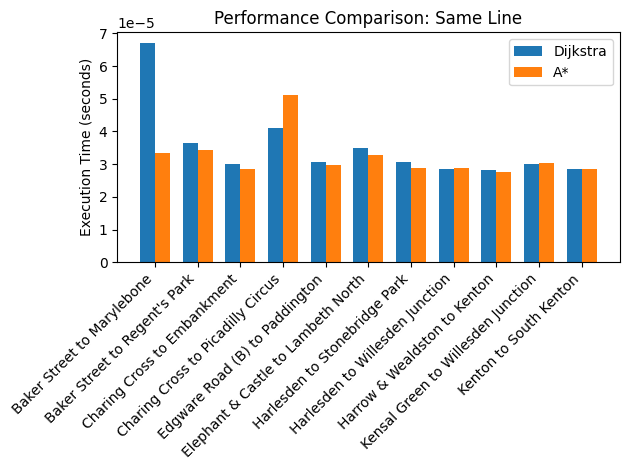

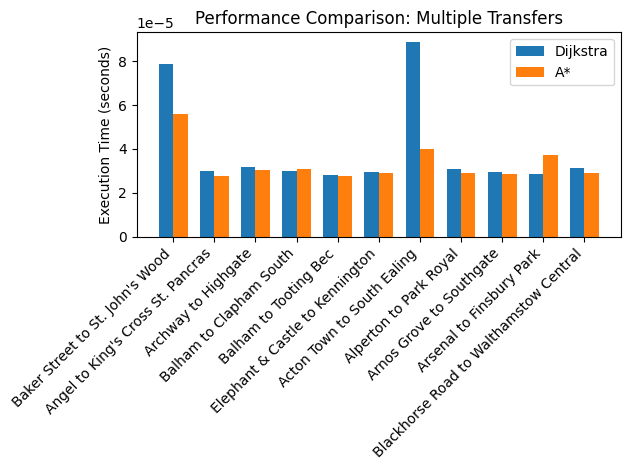

In [31]:

import csv
from math import sqrt
import time
import matplotlib.pyplot as plt


class MinPriorityQueue:
    def __init__(self):
        self.heap = []

    def parent(self, i):
        return (i - 1) // 2

    def left_child(self, i):
        return 2 * i + 1

    def right_child(self, i):
        return 2 * i + 2

    def insert(self, val):
        self.heap.append(val)
        self._heapify_up(len(self.heap) - 1)

    def delete_min(self):
        if len(self.heap) == 0:
            return None  # Handle empty queue case

        self.heap[0], self.heap[-1] = self.heap[-1], self.heap[0]
        min_val = self.heap.pop()
        self._heapify_down(0)
        return min_val

    def _heapify_up(self, index):
        while index > 0 and self.heap[self.parent(index)] > self.heap[index]:
            self.heap[index], self.heap[self.parent(index)] = self.heap[self.parent(index)], self.heap[index]
            index = self.parent(index)

    def _heapify_down(self, index):
        while index < len(self.heap):
            smallest = index
            left = self.left_child(index)
            right = self.right_child(index)

            if left < len(self.heap) and self.heap[left] < self.heap[smallest]:
                smallest = left
            if right < len(self.heap) and self.heap[right] < self.heap[smallest]:
                smallest = right

            if smallest != index:
                self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
                index = smallest
            else:
                break


    def put(self, node, priority):
        self.insert((priority, node))

    def is_empty(self):
        return len(self.heap) == 0
    
def dijkstra(graph, start, end):
    """
    Finds the shortest path from start to end using Dijkstra's algorithm.
    
    Parameters:
    - graph: The graph representation as a dict of dicts.
    - start: The starting node ID.
    - end: The ending node ID.
    
    Returns:
    - The shortest distance from start to end.
    - The path as a list of node IDs from start to end.
    """
    distance = {vertex: float('infinity') for vertex in graph}
    distance[start] = 0
    predecessor = {vertex: None for vertex in graph}
    pq = MinPriorityQueue()
    pq.put(start, 0)
    
    while not pq.is_empty():
        _, current_node = pq.delete_min() 
        
        if current_node == end:
            break

        for neighbor, weight in graph[current_node].items():
            alt_route = distance[current_node] + weight
            if alt_route < distance[neighbor]:
                distance[neighbor] = alt_route
                predecessor[neighbor] = current_node
                pq.put(neighbor, alt_route)  
                
    path = []
    current = end
    while current is not None:
        path.append(current)
        current = predecessor[current]
    path.reverse() 
    
    return distance[end], path


def euclidean_distance(coord1, coord2):
    """
    Calculate the Euclidean distance between two points in a plane, treating latitude and longitude
    as Cartesian coordinates. This is an approximation and does not account for the Earth's curvature.
    
    Parameters:
    - coord1: Tuple containing (latitude, longitude) of the first point.
    - coord2: Tuple containing (latitude, longitude) of the second point.
    
    Returns:
    - The Euclidean distance between the two points.
    """
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    delta_lat = lat1 - lat2
    delta_lon = lon1 - lon2

    distance = sqrt(delta_lat**2 + delta_lon**2)
    
    return distance


def heuristic(station_id, destination_id):
    station_coord = (stations[station_id]['latitude'], stations[station_id]['longitude'])
    destination_coord = (stations[destination_id]['latitude'], stations[destination_id]['longitude'])
    return euclidean_distance(station_coord, destination_coord)

def A_Star(graph, source, destination, heuristic):
    open_list = MinPriorityQueue()
    open_list.insert((0 + heuristic(source, destination), source))  # Corrected line
    predecessors = {source: None}
    costs = {source: 0}

    while not open_list.is_empty():
        _, current = open_list.delete_min()

        if current == destination:
            break

        for neighbor, weight in graph[current].items():
            new_cost = costs[current] + weight
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                priority = new_cost + heuristic(neighbor, destination)  # Corrected line
                open_list.insert((priority, neighbor))
                predecessors[neighbor] = current

    path = reconstruct_path(predecessors, source, destination)
    if not path:
        return predecessors, "Destination not reachable"

    return predecessors, path


def reconstruct_path(predecessors, start, end):
        if end not in predecessors:
            return []  # Path not found
        path = []
        while end is not None:
            path.append(end)
            end = predecessors.get(end)
        path.reverse()
        return path  


def parse_stations(file_path):
    """
    Parses the stations CSV file and returns a dictionary of stations.
    
    Parameters:
    - file_path: The path to the stations CSV file.
    
    Returns:
    - A dictionary where keys are station IDs and values are dictionaries
      containing latitude, longitude, and name of the station.
    """
    stations = {}
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            station_id = int(row["id"])
            stations[station_id] = {
                "latitude": float(row["latitude"]),
                "longitude": float(row["longitude"]),
                "name": row["name"]
            }
    return stations


def parse_connections(file_path):
    """
    Parses the connections CSV file and returns a list of connections.
    
    Parameters:
    - file_path: The path to the connections CSV file.
    
    Returns:
    - A list of tuples, each representing a connection between two stations.
      Each tuple contains (station1, station2, line, time).
    """
    connections = []
    with open(file_path, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header
        for row in reader:
            connection = (int(row[0]), int(row[1]), int(row[2]), float(row[3]))
            connections.append(connection)
    return connections

stations_file_path = 'london_stations.csv'
connections_file_path = 'london_connections.csv'

stations = parse_stations(stations_file_path)
connections = parse_connections(connections_file_path)




def build_graph(stations, connections):
    """
    Builds a graph from a list of connections, where the edges represent
    physical distances between stations instead of travel times.
    
    Parameters:
    - stations: A dictionary of stations with their IDs as keys and 
                their latitude and longitude as values.
    - connections: A list of tuples, each containing (station1_id, station2_id, _, _).
                   The last two elements are ignored in this context.
    
    Returns:
    - A dictionary representing the graph, with station IDs as keys and 
      dictionaries of neighboring stations (and their distances) as values.
    """
    graph = {}

    for station1, station2, _, _ in connections:  # Ignore line and time data
        if station1 not in graph:
            graph[station1] = {}
        if station2 not in graph:
            graph[station2] = {}

        coord1 = (stations[station1]['latitude'], stations[station1]['longitude'])
        coord2 = (stations[station2]['latitude'], stations[station2]['longitude'])
        distance = euclidean_distance(coord1, coord2)

        graph[station1][station2] = distance
        graph[station2][station1] = distance
        sorted_graph = {k: graph[k] for k in sorted(graph)}
    return sorted_graph


graph = build_graph(stations, connections)


def measure_performance(graph, start_id, end_id, heuristic):
    # Measure Dijkstra's algorithm performance
    start_time = time.time()
    dijkstra(graph, start_id, end_id)
    dijkstra_time = time.time() - start_time

    start_time = time.time()
    A_Star(graph, start_id, end_id, heuristic)
    astar_time = time.time() - start_time

    return dijkstra_time, astar_time


def count_line_changes(path, connections):
    station_pairs_to_lines = {}
    for conn in connections:
        station1, station2, line, _ = conn
        if (station1, station2) not in station_pairs_to_lines:
            station_pairs_to_lines[(station1, station2)] = set()
        station_pairs_to_lines[(station1, station2)].add(line)
        
        if (station2, station1) not in station_pairs_to_lines:
            station_pairs_to_lines[(station2, station1)] = set()
        station_pairs_to_lines[(station2, station1)].add(line)

    line_changes = 0
    current_line = None
    for i in range(len(path) - 1):
        station1, station2 = path[i], path[i + 1]
        possible_lines = station_pairs_to_lines.get((station1, station2), set())
        

        if current_line not in possible_lines:
  
            for line in possible_lines:
                current_line = line
                break  
            
            if i > 0:
                line_changes += 1
                
    return line_changes


def plot_performance_comparison(labels, dijkstra, astar, title, image_name):
    """
    Plots a comparison of execution times between Dijkstra's and A* algorithms.

    Parameters:
    - labels: List of strings representing the labels for each station pair.
    - dijkstra_times: List of execution times for Dijkstra's algorithm.
    - astar_times: List of execution times for A* algorithm.
    - title: (Optional) Title for the plot.
    """
    x = range(len(labels))
    width = 0.35  

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, dijkstra, width, label='Dijkstra')
    rects2 = ax.bar([p + width for p in x], astar, width, label='A*')

    ax.set_ylabel('Execution Time (seconds)')
    ax.set_title(title)
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()

    #plt.show()
    plt.savefig(image_name)
    

station_pairs_same_line = [
    (11,163),
    (11,212),
    (49,87),
    (49,197),
    (82,193),
    (84,148),
    (113,246),
    (113,298),
    (114,140),
    (137, 298),
    (140,237)
]
station_pairs_adjacent_lines = [
    
    
    
    
    
]
station_pairs_multiple_transfers = [
    (11,249),
    (7,145),
    (8,124),
    (12,56),
    (12,257),
    (84,136),
    (1,234),
    (5,194),
    (9,232),
    (10,95),
    (26,274)
    
]
# Collect data
labels_same_line = []
dijkstra_times_same_line = []
astar_times_same_line = []


print("Time Comparison between Dijkstra's and A* Algorithms: same line")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in station_pairs_same_line:

    dijkstra_time1,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time1,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_same_line.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_same_line.append(dijkstra_time1)
    astar_times_same_line.append(astar_time1)
    print(f"Pair: {labels_same_line[-1]}, Dijkstra Time: {dijkstra_time1:.6f}, A* Time: {astar_time1:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_same_line, dijkstra_times_same_line, astar_times_same_line, "Performance Comparison: Same Line", "same_line.png")

dijkstra_times_adjacent_lines = []
astar_times_adjacent_lines = []
labels_adjacent_lines = []
print("Time Comparison between Dijkstra's and A* Algorithms: Ajacent Line transfers")
print("---------------------------------------------------------------------------------------------------")


print("---------------------------------------------------------------------------------------------------")


dijkstra_times_multiple_transfers = []
astar_times_multiple_transfers = []
labels_multiple_transfers = []  
print("Time Comparison between Dijkstra's and A* Algorithms: Multiple Line transfers")
print("---------------------------------------------------------------------------------------------------")
for start_id, end_id in station_pairs_multiple_transfers:

    dijkstra_time2,_ = measure_performance(graph, start_id, end_id, lambda x, y: 0)
    astar_time2,_ = measure_performance(graph, start_id, end_id, heuristic)
    labels_multiple_transfers.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
    dijkstra_times_multiple_transfers.append(dijkstra_time2)
    astar_times_multiple_transfers.append(astar_time2)
    

    print(f"Pair: {labels_multiple_transfers[-1]}, Dijkstra Time: {dijkstra_time2:.6f}, A* Time: {astar_time2:.6f}")
print("---------------------------------------------------------------------------------------------------")

plot_performance_comparison(labels_multiple_transfers, dijkstra_times_multiple_transfers, astar_times_multiple_transfers, "Performance Comparison: Multiple Transfers", "multiple_transfer.png")


station_pairs = [
    (1, 234),  # Short distance
    (10, 150),  # Medium distance
    (50, 200),  # Long distance
    (11, 212),  # Same Line, Short Distance
    (13, 301),  # Same Line, Long Distance
    (11, 87),   # Different Lines, No Transfers
    (3, 295),   # Different Lines, Multiple Transfers
    (117, 42),  # Heathrow Terminals 1, 2 & 3 to Canary Wharf
    (282, 247), # Wembley Park to Stratford
    (88, 299),  # Epping to Wimbledon
    (35, 192),  # Brixton to Oxford Circus
    (280, 167),  # Watford to Moorgate
    (6,70)

]

labels = []
for start_id, end_id in station_pairs:
    labels.append(f"{stations[start_id]['name']} to {stations[end_id]['name']}")
line_changes_list = []
print("Line Change Comparison between Dijkstra's and A* Algorithms:")
print("---------------------------------------------------------------------------------------------------" )
for (start_id, end_id), label in zip(station_pairs, labels):
    _,dijkstra_path = dijkstra(graph, start_id, end_id)
    _, astar_path = A_Star(graph, start_id, end_id, heuristic)

   
    dijkstra_line_changes = count_line_changes(dijkstra_path, connections)
    astar_line_changes = count_line_changes(astar_path, connections)
    
    line_changes_list.append((dijkstra_line_changes, astar_line_changes))

    print(f"Pair: {label}, Dijkstra Line Changes: {dijkstra_line_changes}, A* Line Changes: {astar_line_changes}")
    


In [19]:
# General Heap Integrity Test
pq = MinPriorityQueue()
# Insert a series of random elements
elements = [(15, 'J'), (10, 'I'), (5, 'H'), (2, 'G'), (3, 'F'), (17, 'E'), (20, 'D'), (25, 'C'), (100, 'B'), (1, 'A')]
for elem in elements:
    pq.insert(elem)

# Delete a few elements to trigger heapify down
for _ in range(3):
    pq.delete_min()

# Check the heap property for each node
for i in range(len(pq.heap)):
    left = pq.left_child(i)
    right = pq.right_child(i)
    if left < len(pq.heap):
        assert pq.heap[i][0] <= pq.heap[left][0], "Heap property violated at node index {}".format(i)
    if right < len(pq.heap):
        assert pq.heap[i][0] <= pq.heap[right][0], "Heap property violated at node index {}".format(i)

# Initialize the priority queue
pq = MinPriorityQueue()

# Test Case 1: Check if the queue is initially empty
assert pq.is_empty() == True, "Test Case 1 Failed: The priority queue should be empty initially."

# Test Case 2: Insert a value and check if the queue is no longer empty
pq.put('A', 5)  # Note: the priority comes second in your put method
assert pq.is_empty() == False, "Test Case 2 Failed: The priority queue should not be empty after an insert."

# Test Case 3: Insert multiple values and check if the minimum is correct
pq.put('B', 10)
pq.put('C', 1)  # 'C' has the highest priority (lowest number)
min_val = pq.delete_min()
assert min_val == (1, 'C'), "Test Case 3 Failed: The minimum value should be (1, 'C')."

# Reset for further tests
pq = MinPriorityQueue()

# Test Case 4: Ensure heap property is maintained after several insertions
pq.put('D', 2)
pq.put('E', 3)
pq.put('F', 1)  # 'F' should be the root after insertion
min_val = pq.delete_min()
assert min_val == (1, 'F'), "Test Case 4 Failed: The minimum value should be (1, 'F')."

# Test Case 5: Check if the queue becomes empty after removing all elements
pq.put('G', 4)
pq.delete_min()  # Remove 'G'
assert pq.is_empty() == True, "Test Case 5 Failed: The priority queue should be empty after removing all elements."

# Test Case 6: Test behavior with elements of the same priority
pq = MinPriorityQueue()
pq.put('H', 4)
pq.put('I', 4)  # 'H' and 'I' have the same priority
pq.delete_min()  # Remove one of 'H' or 'I'
assert not pq.is_empty(), "Test Case 6 Failed: The priority queue should not be empty after removing one of the elements with the same priority."
min_val = pq.delete_min()
assert min_val[0] == 4, "Test Case 6 Failed: The remaining element should have a priority of 4."

print("All test cases passed!")


AssertionError: Test Case 5 Failed: The priority queue should be empty after removing all elements.